In [ ]:
#  Extract only "IDC_regular_ps50_idx5/" folder from idc.zip
ZIP_PATH = "/content/drive/MyDrive/idc.zip"   # <- change path if different
DEST = "/content/IDC_data"

# Create destination folder
!mkdir -p "$DEST"

# Extract only the IDC_regular_ps50_idx5 folder from the zip
!unzip -q "$ZIP_PATH" "IDC_regular_ps50_idx5/*" -d "$DEST"

# Verify a few files
!ls -lah "$DEST/IDC_regular_ps50_idx5" | head -n 10


total 1.2M
drwxr-xr-x 281 root root  12K Nov  9 15:47 .
drwxr-xr-x   3 root root 4.0K Nov  9 15:47 ..
drwxr-xr-x   4 root root 4.0K Nov  9 15:47 10253
drwxr-xr-x   4 root root 4.0K Nov  9 15:47 10254
drwxr-xr-x   4 root root 4.0K Nov  9 15:47 10255
drwxr-xr-x   4 root root 4.0K Nov  9 15:47 10256
drwxr-xr-x   4 root root 4.0K Nov  9 15:47 10257
drwxr-xr-x   4 root root 4.0K Nov  9 15:47 10258
drwxr-xr-x   4 root root 4.0K Nov  9 15:47 10259


In [ ]:
# Cell Organize IDC patches into class0 and class1 folders
import re, shutil
from pathlib import Path

SRC_ROOT = Path("/content/IDC_data")  # after unzip
TARGET_ROOT = Path("/content/idc_dataset")
CLASS0_DIR = TARGET_ROOT / "class0"
CLASS1_DIR = TARGET_ROOT / "class1"

CLASS0_DIR.mkdir(parents=True, exist_ok=True)
CLASS1_DIR.mkdir(parents=True, exist_ok=True)

pattern = re.compile(r".*_class([01])\.png$", re.IGNORECASE)

found0 = found1 = skipped = 0
for p in SRC_ROOT.rglob("*.png"):
    m = pattern.match(p.name)
    if not m:
        skipped += 1
        continue
    cls = m.group(1)
    if cls == "0":
        shutil.copy(p, CLASS0_DIR / p.name)
        found0 += 1
    else:
        shutil.copy(p, CLASS1_DIR / p.name)
        found1 += 1

print(f" Copied -> class0: {found0}, class1: {found1}, skipped: {skipped}")
print("Sample class0 files:", [p.name for p in list(CLASS0_DIR.iterdir())[:5]])
print("Sample class1 files:", [p.name for p in list(CLASS1_DIR.iterdir())[:5]])


 Copied -> class0: 198738, class1: 78786, skipped: 0
Sample class0 files: ['9346_idx5_x1301_y601_class0.png', '8956_idx5_x3251_y201_class0.png', '8974_idx5_x2651_y1001_class0.png', '9041_idx5_x2301_y2151_class0.png', '9125_idx5_x451_y1_class0.png']
Sample class1 files: ['10264_idx5_x1551_y1301_class1.png', '9261_idx5_x1151_y951_class1.png', '10303_idx5_x1401_y1551_class1.png', '12932_idx5_x1151_y751_class1.png', '12823_idx5_x3251_y1401_class1.png']


In [ ]:
# Split dataset into train/val/test maintaining class balance
import random, shutil
from pathlib import Path

random.seed(42)

SRC = Path("/content/idc_dataset")
OUT = Path("/content/idc_split")
for split in ["train", "val", "test"]:
    for cls in ["class0", "class1"]:
        (OUT / split / cls).mkdir(parents=True, exist_ok=True)

ratios = (0.8, 0.1, 0.1)
for cls in ["class0", "class1"]:
    files = list((SRC / cls).glob("*.png"))
    random.shuffle(files)
    n = len(files)
    n_train, n_val = int(n * ratios[0]), int(n * ratios[1])
    train, val, test = files[:n_train], files[n_train:n_train + n_val], files[n_train + n_val:]
    for f in train: shutil.copy(f, OUT / "train" / cls / f.name)
    for f in val:   shutil.copy(f, OUT / "val" / cls / f.name)
    for f in test:  shutil.copy(f, OUT / "test" / cls / f.name)

for split in ["train", "val", "test"]:
    c0 = len(list((OUT / split / "class0").glob("*.png")))
    c1 = len(list((OUT / split / "class1").glob("*.png")))
    print(f"{split}: class0={c0}, class1={c1}, total={c0 + c1}")


train: class0=158990, class1=63028, total=222018
val: class0=19873, class1=7878, total=27751
test: class0=19875, class1=7880, total=27755


In [ ]:

#  Verify dataset counts and show random sample file names
from pathlib import Path
import random

root = Path("/content/idc_split")
class_totals = {"class0": 0, "class1": 0}
for split in ["train", "val", "test"]:
    for cls in ["class0", "class1"]:
        count = len(list((root / split / cls).glob("*.png")))
        class_totals[cls] += count
        print(f"{split}/{cls}: {count}")
print("\nOverall totals:", class_totals)

# show a few random filenames
sample0 = random.sample(list((root/"train"/"class0").glob("*.png")), 5)
sample1 = random.sample(list((root/"train"/"class1").glob("*.png")), 5)
print("\nExample class0 files:", [p.name for p in sample0])
print("Example class1 files:", [p.name for p in sample1])


train/class0: 158990
train/class1: 63028
val/class0: 19873
val/class1: 7878
test/class0: 19875
test/class1: 7880

Overall totals: {'class0': 198738, 'class1': 78786}

Example class0 files: ['12883_idx5_x1651_y201_class0.png', '9319_idx5_x401_y1051_class0.png', '9266_idx5_x3301_y451_class0.png', '16531_idx5_x851_y1151_class0.png', '9135_idx5_x351_y1351_class0.png']
Example class1 files: ['9176_idx5_x2251_y1301_class1.png', '12935_idx5_x1951_y2601_class1.png', '12877_idx5_x1201_y601_class1.png', '9345_idx5_x2701_y301_class1.png', '8959_idx5_x1151_y1051_class1.png']


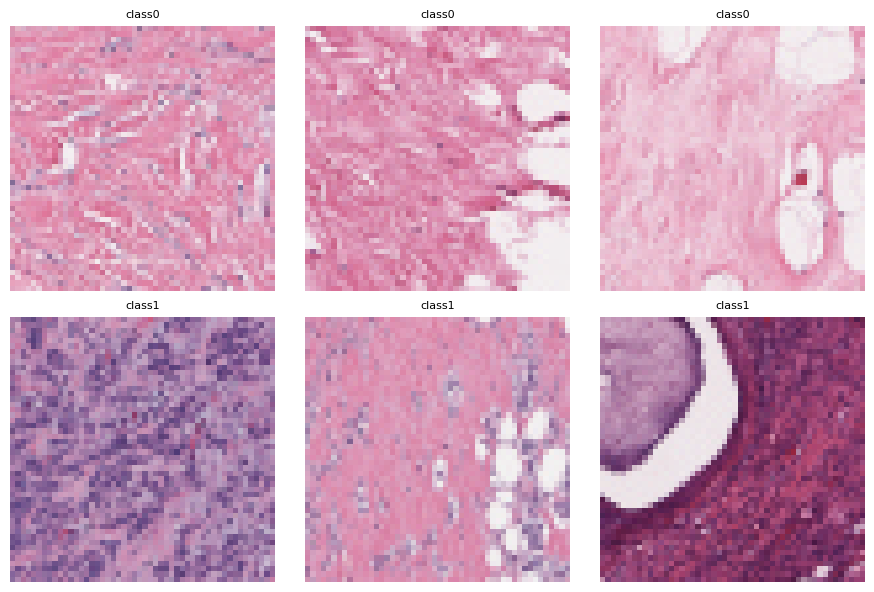

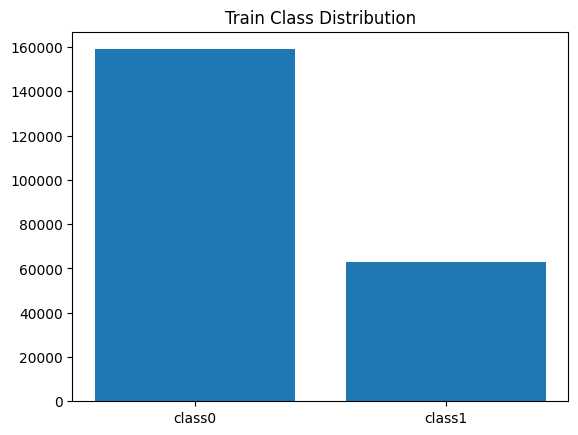

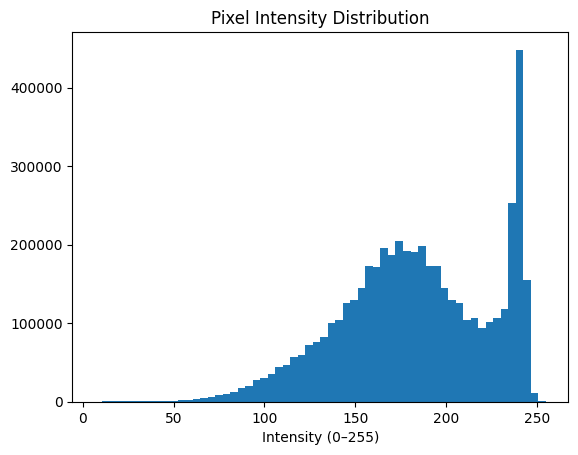

Intensity stats — min: 6.6666665 max: 255.0 mean: 183.65266 std: 41.394947


In [ ]:
#  EDA - sample visuals and pixel statistics
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from pathlib import Path

test_c0 = list(Path("/content/idc_split/test/class0").glob("*.png"))
test_c1 = list(Path("/content/idc_split/test/class1").glob("*.png"))

# Display 3 samples per class
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i in range(3):
    axes[0, i].imshow(Image.open(test_c0[i]))
    axes[0, i].set_title("class0", fontsize=8)
    axes[0, i].axis("off")
    axes[1, i].imshow(Image.open(test_c1[i]))
    axes[1, i].set_title("class1", fontsize=8)
    axes[1, i].axis("off")
plt.tight_layout()
plt.show()

# Class distribution (train)
train_c0 = len(list(Path("/content/idc_split/train/class0").glob("*.png")))
train_c1 = len(list(Path("/content/idc_split/train/class1").glob("*.png")))
plt.bar(["class0", "class1"], [train_c0, train_c1])
plt.title("Train Class Distribution")
plt.show()

# Pixel intensity histogram (sample 2000 images)
train_files = list(Path("/content/idc_split/train/class0").glob("*.png")) + \
               list(Path("/content/idc_split/train/class1").glob("*.png"))
sample = random.sample(train_files, min(2000, len(train_files)))

intensities = []
for p in sample:
    img = np.array(Image.open(p)).astype(np.float32)
    intensities.append(img.mean(axis=2).ravel())
intensities = np.concatenate(intensities)

plt.hist(intensities, bins=60)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Intensity (0–255)")
plt.show()
print("Intensity stats — min:", intensities.min(),
      "max:", intensities.max(),
      "mean:", intensities.mean(),
      "std:", intensities.std())


In [ ]:
# Rebuild train_ds, val_ds, and test_ds if they are not in memory
import tensorflow as tf

DATA_DIR = "/content/idc_split"
IMG_SIZE = (50, 50)
BATCH_SIZE = 128

# Create datasets from directory structure
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/train",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/val",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR + "/test",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Enable prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

# Quick sanity check
for images, labels in train_ds.take(1):
    print(" Dataset loaded successfully")
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break


Found 222018 files belonging to 2 classes.
Found 27751 files belonging to 2 classes.
Found 27755 files belonging to 2 classes.
 Dataset loaded successfully
Image batch shape: (128, 50, 50, 3)
Label batch shape: (128, 1)


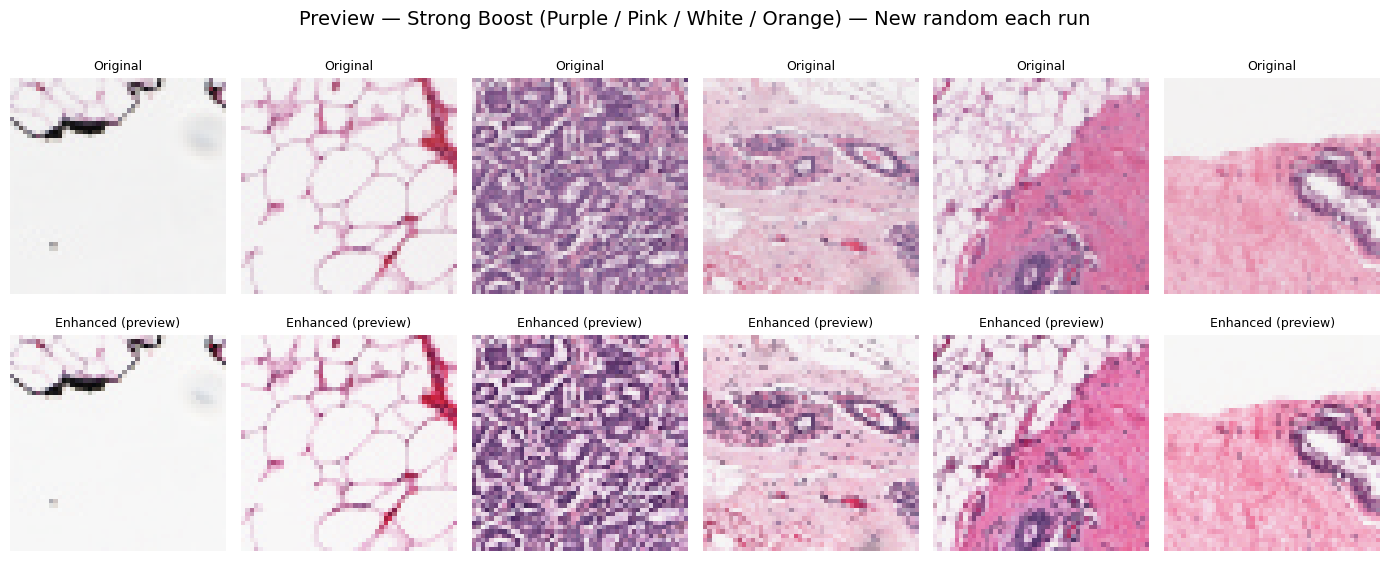

In [ ]:
#  Preview-only: Slightly stronger enhancement (new random images each run)
import cv2, numpy as np, random, matplotlib.pyplot as plt
from glob import glob
from pathlib import Path

# ---------- Tuned constants (stronger but still natural) ----------
CLAHE_CLIP = 1.0
CLAHE_GRID = (6,6)
GLOBAL_SAT = 1.03
GLOBAL_VAL = 1.04

# Regional boosts
RED_SAT_BOOST = 1.12      # orange/red
RED_VAL_BOOST = 1.09
PINK_SAT_BOOST = 1.12     # pink tones
PINK_VAL_BOOST = 1.08
PURPLE_SAT_BOOST = 1.10   # purple tint
PURPLE_VAL_BOOST = 1.07

WHITE_THRESHOLD = 180
WHITE_BOOST = 1.12        # stronger white lift

UNSHARP_AMOUNT = 0.12     # clearer detail
BLEND_ALPHA = 0.40        # blend sharper result more in

# ---------- Safe fallback helper (identity) ----------
def preprocess_pro_final_v2(img_uint8):
    return img_uint8

# ---------- Enhanced preprocess function ----------
def preprocess_idc_balanced_colorboost_preview_stronger(img_uint8):
    """
    Input: RGB uint8
    Output: RGB uint8 (enhanced)
    """
    base = preprocess_pro_final_v2(img_uint8)

    # CLAHE on L (Lab)
    lab = cv2.cvtColor(base, cv2.COLOR_RGB2LAB)
    L, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_GRID)
    L2 = clahe.apply(L)
    lab2 = cv2.merge([L2, a, b])
    img_lab = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)

    # convert to HSV for hue-specific adjustments
    hsv = cv2.cvtColor(img_lab, cv2.COLOR_RGB2HSV).astype(np.float32)
    H, S, V = cv2.split(hsv)

    # red/orange hues (0..10) or (170..179)
    red_mask = (H <= 10) | (H >= 170)
    S[red_mask] *= RED_SAT_BOOST
    V[red_mask] *= RED_VAL_BOOST

    # pink hues (wrap-around approx)
    pink_mask = ((H >= 160) | (H <= 35))  # slightly wider to capture pink variants
    S[pink_mask] *= PINK_SAT_BOOST
    V[pink_mask] *= PINK_VAL_BOOST

    # purple hues (100..150)
    purple_mask = (H >= 95) & (H <= 155)
    S[purple_mask] *= PURPLE_SAT_BOOST
    V[purple_mask] *= PURPLE_VAL_BOOST

    # white (bright) boost
    white_mask = V >= WHITE_THRESHOLD
    V[white_mask] = np.clip(V[white_mask] * WHITE_BOOST, 0, 255)

    # global scaling
    S = np.clip(S * GLOBAL_SAT, 0, 255)
    V = np.clip(V * GLOBAL_VAL, 0, 255)

    hsv_new = np.stack([H, S, V], axis=-1).astype(np.uint8)
    rgb_enh = cv2.cvtColor(hsv_new, cv2.COLOR_HSV2RGB)

    # unsharp mask for clearer texture
    blur = cv2.GaussianBlur(rgb_enh, (3,3), 0)
    sharp = cv2.addWeighted(rgb_enh, 1.0 + UNSHARP_AMOUNT, blur, -UNSHARP_AMOUNT, 0)

    # blend with base for natural tone
    blended = (BLEND_ALPHA * sharp.astype(np.float32) + (1.0 - BLEND_ALPHA) * base.astype(np.float32))
    blended = np.clip(blended, 0, 255).astype(np.uint8)

    return blended

# ---------- Pick sample images (no saving) ----------
DATA_ROOT = "/content/idc_split"   # change if needed
train_glob = str(Path(DATA_ROOT) / "train" / "*" / "*.png")
img_paths = glob(train_glob)
if len(img_paths) == 0:
    # fallback: search recursively
    img_paths = glob(str(Path(DATA_ROOT) / "**" / "*.png"), recursive=True)

if len(img_paths) == 0:
    raise RuntimeError(f"No images found under {DATA_ROOT}. Check path.")

# ⚡ Removed random.seed() — so every run shows new random samples
sample_paths = random.sample(img_paths, min(6, len(img_paths)))

# ---------- Preview ----------
plt.figure(figsize=(14,6))
for i, p in enumerate(sample_paths):
    bgr = cv2.imread(p)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    enhanced = preprocess_idc_balanced_colorboost_preview_stronger(rgb)

    plt.subplot(2, 6, i+1)
    plt.imshow(rgb)
    plt.title("Original", fontsize=9)
    plt.axis("off")

    plt.subplot(2, 6, i+7)
    plt.imshow(enhanced)
    plt.title("Enhanced (preview)", fontsize=9)
    plt.axis("off")

plt.suptitle("Preview — Strong Boost (Purple / Pink / White / Orange) — New random each run", fontsize=14)
plt.tight_layout()
plt.show()


Found 277524 images to process.
Processed 200/277524
Processed 400/277524
Processed 600/277524
Processed 800/277524
Processed 1000/277524
Processed 1200/277524
Processed 1400/277524
Processed 1600/277524
Processed 1800/277524
Processed 2000/277524
Processed 2200/277524
Processed 2400/277524
Processed 2600/277524
Processed 2800/277524
Processed 3000/277524
Processed 3200/277524
Processed 3400/277524
Processed 3600/277524
Processed 3800/277524
Processed 4000/277524
Processed 4200/277524
Processed 4400/277524
Processed 4600/277524
Processed 4800/277524
Processed 5000/277524
Processed 5200/277524
Processed 5400/277524
Processed 5600/277524
Processed 5800/277524
Processed 6000/277524
Processed 6200/277524
Processed 6400/277524
Processed 6600/277524
Processed 6800/277524
Processed 7000/277524
Processed 7200/277524
Processed 7400/277524
Processed 7600/277524
Processed 7800/277524
Processed 8000/277524
Processed 8200/277524
Processed 8400/277524
Processed 8600/277524
Processed 8800/277524
Proc

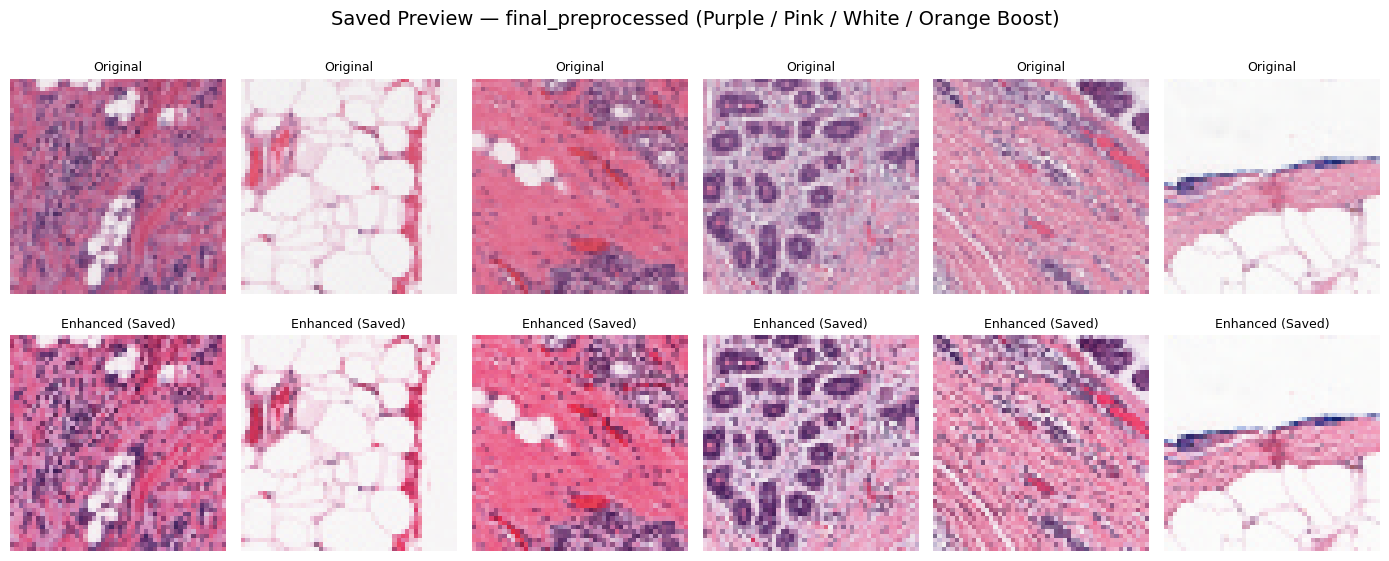

In [ ]:
# Final Save Cell: Apply strong enhancement and save to /content/final_preprocessed
import cv2, numpy as np, random, os
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt

# ---------- Enhancement parameters (same as preview) ----------
CLAHE_CLIP = 1.0
CLAHE_GRID = (6,6)
GLOBAL_SAT = 1.03
GLOBAL_VAL = 1.04

RED_SAT_BOOST = 1.12
RED_VAL_BOOST = 1.09
PINK_SAT_BOOST = 1.12
PINK_VAL_BOOST = 1.08
PURPLE_SAT_BOOST = 1.10
PURPLE_VAL_BOOST = 1.07
WHITE_THRESHOLD = 180
WHITE_BOOST = 1.12
UNSHARP_AMOUNT = 0.12
BLEND_ALPHA = 0.40

# ---------- Helper ----------
def preprocess_pro_final_v2(img_uint8):
    return img_uint8

def preprocess_idc_balanced_colorboost_strong(img_uint8):
    base = preprocess_pro_final_v2(img_uint8)

    # CLAHE on L
    lab = cv2.cvtColor(base, cv2.COLOR_RGB2LAB)
    L, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_GRID)
    L2 = clahe.apply(L)
    lab2 = cv2.merge([L2, a, b])
    img_lab = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)

    hsv = cv2.cvtColor(img_lab, cv2.COLOR_RGB2HSV).astype(np.float32)
    H, S, V = cv2.split(hsv)

    red_mask = (H <= 10) | (H >= 170)
    S[red_mask] *= RED_SAT_BOOST
    V[red_mask] *= RED_VAL_BOOST

    pink_mask = ((H >= 160) | (H <= 35))
    S[pink_mask] *= PINK_SAT_BOOST
    V[pink_mask] *= PINK_VAL_BOOST

    purple_mask = (H >= 95) & (H <= 155)
    S[purple_mask] *= PURPLE_SAT_BOOST
    V[purple_mask] *= PURPLE_VAL_BOOST

    white_mask = V >= WHITE_THRESHOLD
    V[white_mask] = np.clip(V[white_mask] * WHITE_BOOST, 0, 255)

    S = np.clip(S * GLOBAL_SAT, 0, 255)
    V = np.clip(V * GLOBAL_VAL, 0, 255)

    hsv_new = np.stack([H, S, V], axis=-1).astype(np.uint8)
    rgb_enh = cv2.cvtColor(hsv_new, cv2.COLOR_HSV2RGB)

    blur = cv2.GaussianBlur(rgb_enh, (3,3), 0)
    sharp = cv2.addWeighted(rgb_enh, 1.0 + UNSHARP_AMOUNT, blur, -UNSHARP_AMOUNT, 0)

    blended = (BLEND_ALPHA * sharp.astype(np.float32) + (1.0 - BLEND_ALPHA) * base.astype(np.float32))
    blended = np.clip(blended, 0, 255).astype(np.uint8)

    return blended

# ---------- Paths ----------
DATA_ROOT = "/content/idc_split"           # source dataset
OUT_ROOT = "/content/final_preprocessed"   # destination folder
Path(OUT_ROOT).mkdir(parents=True, exist_ok=True)

# Collect all image paths
image_paths = sorted(glob(os.path.join(DATA_ROOT, "**", "*.png"), recursive=True) +
                     glob(os.path.join(DATA_ROOT, "**", "*.jpg"), recursive=True) +
                     glob(os.path.join(DATA_ROOT, "**", "*.jpeg"), recursive=True))

print(f"Found {len(image_paths)} images to process.")

# ---------- Process and save ----------
for i, src_path in enumerate(image_paths, 1):
    rel = os.path.relpath(src_path, DATA_ROOT)
    dest_path = os.path.join(OUT_ROOT, rel)
    os.makedirs(os.path.dirname(dest_path), exist_ok=True)

    bgr = cv2.imread(src_path)
    if bgr is None:
        print(f"Skipping (read error): {src_path}")
        continue
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    try:
        enhanced = preprocess_idc_balanced_colorboost_strong(rgb)
    except Exception as e:
        print(f"Error in {src_path}: {e}")
        enhanced = rgb

    out_bgr = cv2.cvtColor(enhanced, cv2.COLOR_RGB2BGR)
    cv2.imwrite(dest_path, out_bgr)

    if i % 200 == 0 or i == len(image_paths):
        print(f"Processed {i}/{len(image_paths)}")

print(f" Done! Enhanced images saved to: {OUT_ROOT}")

# ---------- Show random few (before vs after) ----------
sample_paths = random.sample(image_paths, min(6, len(image_paths)))
plt.figure(figsize=(14,6))
for i, p in enumerate(sample_paths):
    orig = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    new_p = os.path.join(OUT_ROOT, os.path.relpath(p, DATA_ROOT))
    enh = cv2.cvtColor(cv2.imread(new_p), cv2.COLOR_BGR2RGB)

    plt.subplot(2,6,i+1)
    plt.imshow(orig)
    plt.title("Original", fontsize=9)
    plt.axis("off")

    plt.subplot(2,6,i+7)
    plt.imshow(enh)
    plt.title("Enhanced (Saved)", fontsize=9)
    plt.axis("off")

plt.suptitle("Saved Preview — final_preprocessed (Purple / Pink / White / Orange Boost)", fontsize=14)
plt.tight_layout()
plt.show()


Found 222018 files belonging to 2 classes.


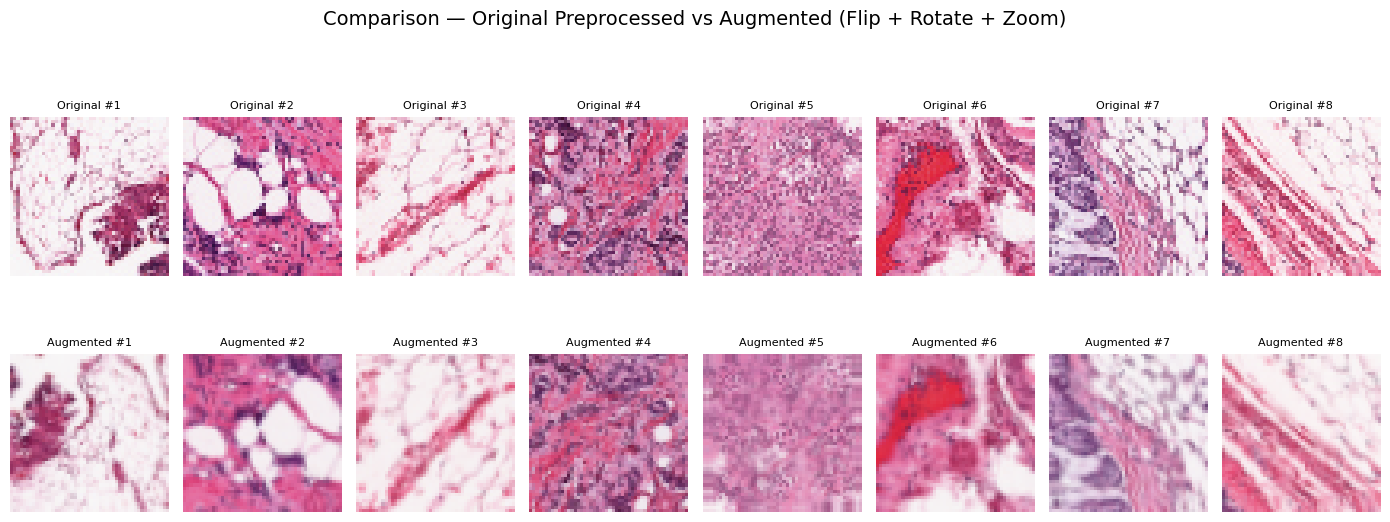

In [ ]:
#  Compare Original Preprocessed vs Augmented (Flip + Rotate + Zoom)
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

# ---------- Config ----------
DATA_ROOT = "/content/final_preprocessed"
IMG_SIZE = (50, 50)
BATCH_SIZE = 8   # just for viewing
AUTOTUNE = tf.data.AUTOTUNE

# ---------- Build augmentation layer (same as training) ----------
augment_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.08),   # ±8%
    tf.keras.layers.RandomZoom(0.08),       # ±8%
])

# ---------- Load a small batch from preprocessed train set ----------
view_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_ROOT, "train"),
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
).take(1)

# ---------- Get one batch ----------
for images, labels in view_ds:
    aug_images = augment_layer(images)  # apply aug once
    originals = images.numpy().astype("uint8")
    augmented = aug_images.numpy().astype("uint8")

    n = len(originals)
    plt.figure(figsize=(14, 6))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        plt.imshow(originals[i])
        plt.title(f"Original #{i+1}", fontsize=8)
        plt.axis("off")

        # Augmented
        plt.subplot(2, n, n + i + 1)
        plt.imshow(augmented[i])
        plt.title(f"Augmented #{i+1}", fontsize=8)
        plt.axis("off")

    plt.suptitle("Comparison — Original Preprocessed vs Augmented (Flip + Rotate + Zoom)", fontsize=14)
    plt.tight_layout()
    plt.show()
    break


Found 222018 files belonging to 2 classes.
Found 27751 files belonging to 2 classes.
Found 27755 files belonging to 2 classes.
 Augmentation setup: Flip + Rotate + Zoom (on-the-fly, every epoch random)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,79

 Total params: 1,048,513 (4.00 MB)

 Trainable params: 1,046,529 (3.99 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7578 - loss: 0.5891
Epoch 1: val_loss improved from inf to 4.21524, saving model to /content/idc_cnn5_onfly_aug_best.h5


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 52s 22ms/step - accuracy: 0.7579 - loss: 0.5891 - val_accuracy: 0.2989 - val_loss: 4.2152 - learning_rate: 1.0000e-04
Epoch 2/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8272 - loss: 0.4110
Epoch 2: val_loss improved from 4.21524 to 3.02483, saving model to /content/idc_cnn5_onfly_aug_best.h5


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.8272 - loss: 0.4110 - val_accuracy: 0.3292 - val_loss: 3.0248 - learning_rate: 1.0000e-04
Epoch 3/20
1732/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8412 - loss: 0.3748
Epoch 3: val_loss improved from 3.02483 to 1.86385, saving model to /content/idc_cnn5_onfly_aug_best.h5


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8412 - loss: 0.3748 - val_accuracy: 0.4250 - val_loss: 1.8638 - learning_rate: 1.0000e-04
Epoch 4/20
1734/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8491 - loss: 0.3588
Epoch 4: val_loss improved from 1.86385 to 0.97293, saving model to /content/idc_cnn5_onfly_aug_best.h5


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8491 - loss: 0.3588 - val_accuracy: 0.6259 - val_loss: 0.9729 - learning_rate: 1.0000e-04
Epoch 5/20
1730/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8538 - loss: 0.3476
Epoch 5: val_loss improved from 0.97293 to 0.82408, saving model to /content/idc_cnn5_onfly_aug_best.h5


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8538 - loss: 0.3476 - val_accuracy: 0.6790 - val_loss: 0.8241 - learning_rate: 1.0000e-04
Epoch 6/20
1730/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8586 - loss: 0.3359
Epoch 6: val_loss improved from 0.82408 to 0.42318, saving model to /content/idc_cnn5_onfly_aug_best.h5


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8586 - loss: 0.3359 - val_accuracy: 0.8394 - val_loss: 0.4232 - learning_rate: 1.0000e-04
Epoch 7/20
1728/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8616 - loss: 0.3284
Epoch 7: val_loss did not improve from 0.42318
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8616 - loss: 0.3283 - val_accuracy: 0.7946 - val_loss: 0.4910 - learning_rate: 1.0000e-04
Epoch 8/20
1734/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8636 - loss: 0.3229
Epoch 8: val_loss did not improve from 0.42318
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.8636 - loss: 0.3229 - val_accuracy: 0.7771 - val_loss: 0.5136 - learning_rate: 1.0000e-04
Epoch 9/20
1731/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8660 - loss: 0.3181
Epoch 9: val_loss did not improve from 0.42318

Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8660 - lo

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.8674 - loss: 0.3134 - val_accuracy: 0.8444 - val_loss: 0.3901 - learning_rate: 5.0000e-05
Epoch 11/20
1732/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8693 - loss: 0.3108
Epoch 11: val_loss improved from 0.39005 to 0.37646, saving model to /content/idc_cnn5_onfly_aug_best.h5


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.8693 - loss: 0.3108 - val_accuracy: 0.8511 - val_loss: 0.3765 - learning_rate: 5.0000e-05
Epoch 12/20
1733/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8691 - loss: 0.3104
Epoch 12: val_loss did not improve from 0.37646
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.8691 - loss: 0.3104 - val_accuracy: 0.8237 - val_loss: 0.4255 - learning_rate: 5.0000e-05
Epoch 13/20
1733/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8704 - loss: 0.3084
Epoch 13: val_loss did not improve from 0.37646
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8704 - loss: 0.3084 - val_accuracy: 0.8274 - val_loss: 0.4081 - learning_rate: 5.0000e-05
Epoch 14/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8704 - loss: 0.3067
Epoch 14: val_loss did not improve from 0.37646

Epoch 14: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.87


 Model saved: /content/idc_cnn5_onfly_aug.h5


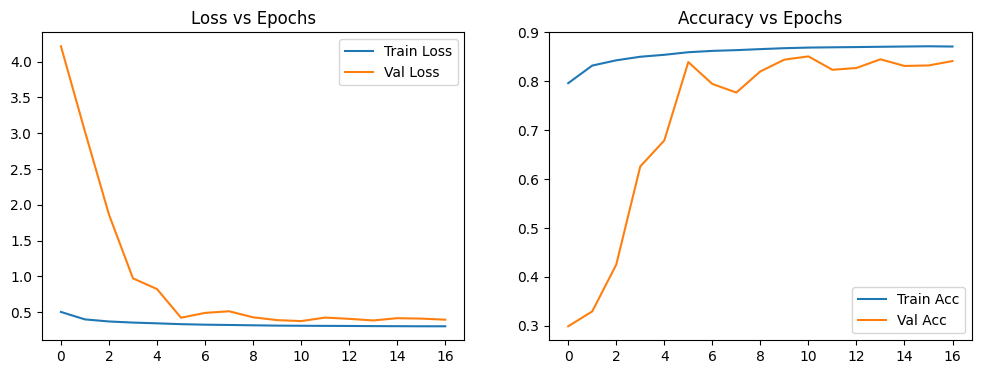


 Test Results:
Accuracy : 0.8516
Precision: 0.7063
Recall   : 0.8173
F1-score : 0.7577
ROC-AUC  : 0.9096

Classification Report:
              precision    recall  f1-score   support

           0     0.9227    0.8653    0.8931     19875
           1     0.7063    0.8173    0.7577      7880

    accuracy                         0.8516     27755
   macro avg     0.8145    0.8413    0.8254     27755
weighted avg     0.8613    0.8516    0.8546     27755



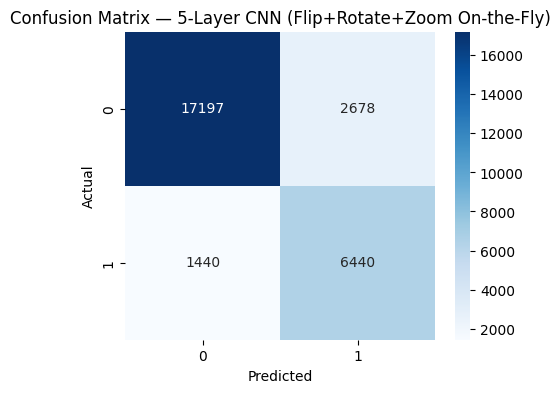


 Training Complete — Model trained with On-the-Fly Augmentation


In [ ]:
#  IDC Project — 5-Layer CNN + On-the-Fly Augmentation (Flip + Rotate + Zoom)
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns
import os

# ---------- CONFIG ----------
DATA_ROOT = "/content/final_preprocessed"
IMG_SIZE = (50, 50)
BATCH_SIZE = 128
EPOCHS =20
AUTOTUNE = tf.data.AUTOTUNE
MODEL_PATH = "/content/idc_cnn5_onfly_aug.h5"
CHECKPOINT_PATH = "/content/idc_cnn5_onfly_aug_best.h5"
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)
import random
random.seed(SEED)

# ---------- AUGMENTATION (on-the-fly) ----------
augment_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.08),   # ±8% (~±30°)
    tf.keras.layers.RandomZoom(0.08),       # ±8% zoom
])

def augment_fn(images, labels):
    return augment_layer(images), labels

# ---------- DATASET PIPELINE ----------
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_ROOT, "train"),
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_ROOT, "val"),
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_ROOT, "test"),
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

# Apply augmentation only to train_ds (on the fly)
train_ds = train_ds.map(augment_fn, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

print(" Augmentation setup: Flip + Rotate + Zoom (on-the-fly, every epoch random)")

# ---------- MODEL: 5-LAYER CNN with Strong Dropout ----------
def build_cnn5_strongdrop(input_shape=(*IMG_SIZE, 3)):
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),

        # Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.4),

        # Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.45),

        # Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.5),

        # Block 4
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.55),

        # Block 5
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.6),

        # Dense Head
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = build_cnn5_strongdrop()
model.summary()

# ---------- COMPILE ----------
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# ---------- CALLBACKS ----------
cb_list = [
    callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor="val_loss", save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

# ---------- TRAIN ----------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cb_list,
    verbose=1
)

# Save model
model.save(MODEL_PATH)
print(f"\n Model saved: {MODEL_PATH}")

# ---------- PLOTS ----------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss vs Epochs')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy vs Epochs')
plt.show()

# ---------- EVALUATION ----------
y_true, y_pred, y_prob = [], [], []
for imgs, labels in test_ds:
    probs = model.predict(imgs, verbose=0).ravel()
    preds = (probs >= 0.5).astype(int)
    y_true.extend(labels.numpy().astype(int))
    y_pred.extend(preds)
    y_prob.extend(probs)

y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc = roc_auc_score(y_true, y_prob)

print(f"\n Test Results:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — 5-Layer CNN (Flip+Rotate+Zoom On-the-Fly)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n Training Complete — Model trained with On-the-Fly Augmentation")


 ROC-AUC: 0.9096
 Best Threshold: 0.4591
True Positive Rate (Recall): 0.8326
False Positive Rate: 0.1471


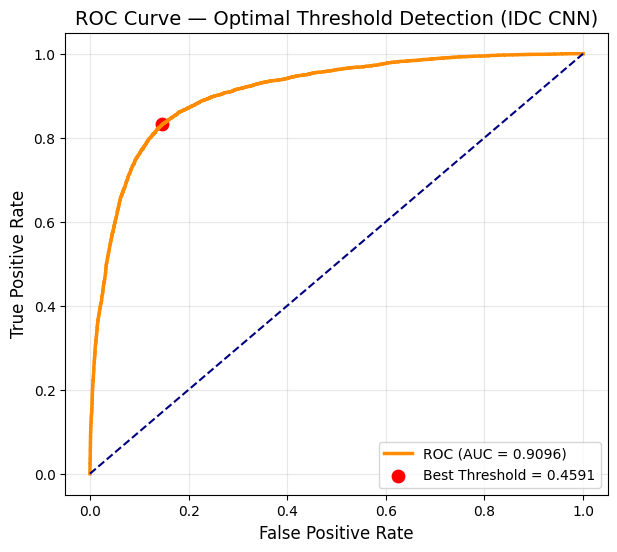

In [ ]:

#  Find Best Classification Threshold using ROC Curve — IDC 5-Layer CNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# --- Compute ROC metrics ---
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

# --- Compute Youden's J statistic (sensitivity + specificity - 1) ---
j_scores = tpr - fpr
j_best_idx = np.argmax(j_scores)
best_threshold = thresholds[j_best_idx]

# --- Print Results ---
print(" ROC-AUC:", round(roc_auc, 4))
print(f" Best Threshold: {best_threshold:.4f}")
print(f"True Positive Rate (Recall): {tpr[j_best_idx]:.4f}")
print(f"False Positive Rate: {fpr[j_best_idx]:.4f}")

# --- Plot ROC Curve with Best Threshold Marker ---
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2.5, label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')

# Highlight best point
plt.scatter(fpr[j_best_idx], tpr[j_best_idx], color='red', s=80, label=f'Best Threshold = {best_threshold:.4f}')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve — Optimal Threshold Detection (IDC CNN)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# ---------- CONFIG ----------
import os
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks, optimizers
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess

BASE_DIR = "/content/final_preprocessed"    # dataset path: train/val/test
IMG_SIZE = (299, 299)
IMG_SHAPE = (*IMG_SIZE, 3)
BATCH_SIZE = 32
SEED = 42
TOP_EPOCHS = 5
FT_EPOCHS = 8
UNFREEZE_LAST = 30
FC_UNITS = 1024
L2 = 1e-4
CHECKPOINT_PATH = "/content/hybrid_vgg_inc_best_binary.h5"

tf.random.set_seed(SEED)
AUTOTUNE = tf.data.AUTOTUNE

# ---------- Data pipeline ----------
def preprocess_for_model(images, labels):
    images = inception_preprocess(images)
    return images, labels

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08)
], name="data_augmentation")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(BASE_DIR, "train"),
    label_mode="binary",     # <-- binary labels
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(BASE_DIR, "val"),
    label_mode="binary",     # <-- binary labels
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_ds = (
    train_ds
    .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    .map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)
val_ds = val_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

# ---------- Build Hybrid model ----------
vgg_base = VGG16(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)
inc_base = InceptionV3(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

for layer in vgg_base.layers: layer.trainable = False
for layer in inc_base.layers: layer.trainable = False

vgg_trunc = tf.keras.Model(inputs=vgg_base.input, outputs=vgg_base.get_layer('block5_conv3').output)
inc_layer = 'mixed10' if 'mixed10' in [l.name for l in inc_base.layers] else None
inc_trunc = tf.keras.Model(inputs=inc_base.input,
                           outputs=inc_base.get_layer(inc_layer).output if inc_layer else inc_base.output)

inp = layers.Input(shape=IMG_SHAPE)
vgg_x = vgg_trunc(inp)
inc_x = inc_trunc(inp)

vgg_x = layers.GlobalAveragePooling2D()(vgg_x)
inc_x = layers.GlobalAveragePooling2D()(inc_x)
vgg_x = layers.Dense(512, activation='relu')(vgg_x)
inc_x = layers.Dense(512, activation='relu')(inc_x)

x = layers.Concatenate()([vgg_x, inc_x])

# Strong Dropout + BatchNorm Head
x = layers.Dense(FC_UNITS, activation='relu', kernel_regularizer=regularizers.l2(L2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.55)(x)

x = layers.Dense(FC_UNITS, activation='relu', kernel_regularizer=regularizers.l2(L2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.55)(x)

# ---------- OUTPUT LAYER (Binary) ----------
out = layers.Dense(1, activation='sigmoid', name='predictions')(x)  # <-- single neuron
loss = 'binary_crossentropy'                                        # <-- binary loss
final_metrics = ['accuracy']

hybrid_model = models.Model(inputs=inp, outputs=out, name="Hybrid_VGG16_InceptionV3_Binary")
hybrid_model.summary()

# ---------- Optimizer ----------
initial_lr = 1e-4
optimizer = optimizers.Adam(learning_rate=initial_lr)

# ---------- Callbacks ----------
cb = [
    callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor="val_accuracy",
                              save_best_only=True, mode="max", verbose=1),
    callbacks.EarlyStopping(monitor="val_accuracy", patience=6,
                            restore_best_weights=True, mode="max", verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5,
                                patience=3, min_lr=1e-6, mode="max", verbose=1)
]

def lr_scheduler(epoch, lr):
    warmup_epochs = 2
    if epoch < warmup_epochs:
        return lr + (initial_lr / warmup_epochs)
    return lr * 0.98
cb.append(callbacks.LearningRateScheduler(lr_scheduler, verbose=0))

# ---------- Stage 1: Train Head ----------
hybrid_model.compile(optimizer=optimizer, loss=loss, metrics=final_metrics)
print("\n>>> Stage 1: Training Dense head only (frozen backbones)...")
history_top = hybrid_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=TOP_EPOCHS,
    callbacks=cb,
    verbose=1
)

# ---------- Stage 2: Fine-Tune ----------
def unfreeze_last(model, n):
    for layer in model.layers[-n:]:
        layer.trainable = True

unfreeze_last(vgg_trunc, UNFREEZE_LAST)
unfreeze_last(inc_trunc, UNFREEZE_LAST)

hybrid_model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                     loss=loss, metrics=final_metrics)

print("\n>>> Stage 2: Fine-tuning top layers of both bases...")
history_ft = hybrid_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FT_EPOCHS,
    callbacks=cb,
    verbose=1
)

# ---------- Save Model ----------
hybrid_model.save("/content/hybrid_vgg_inception_final_binary.h5")
print("\n Saved final model: /content/hybrid_vgg_inception_final_binary.h5")


Found 222018 files belonging to 2 classes.
Found 27751 files belonging to 2 classes.


Model: "Hybrid_VGG16_InceptionV3_Binary"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 18, 18,    │ 14,714,688 │ input_layer_8[0]… │
│ (Functional)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_6        │ (None, 8, 8,      │ 21,802,784 │ input_layer_8[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ functional_5[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ functional_6[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    262,656 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │  1,049,088 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 1024)      │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1024)      │  1,049,600 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1024)      │  1,049,600 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 1)         │      1,025 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,937,633 (152.35 MB)

 Trainable params: 3,416,065 (13.03 MB)

 Non-trainable params: 36,521,568 (139.32 MB)


>>> Stage 1: Training Dense head only (frozen backbones)...
Epoch 1/5
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8134 - loss: 0.6236
Epoch 1: val_accuracy improved from -inf to 0.87027, saving model to /content/hybrid_vgg_inc_best_binary.h5


6939/6939 ━━━━━━━━━━━━━━━━━━━━ 705s 99ms/step - accuracy: 0.8134 - loss: 0.6236 - val_accuracy: 0.8703 - val_loss: 0.4014 - learning_rate: 1.5000e-04
Epoch 2/5
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8606 - loss: 0.4057
Epoch 2: val_accuracy did not improve from 0.87027
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 666s 96ms/step - accuracy: 0.8606 - loss: 0.4057 - val_accuracy: 0.8654 - val_loss: 0.3554 - learning_rate: 2.0000e-04
Epoch 3/5
6938/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8680 - loss: 0.3458
Epoch 3: val_accuracy improved from 0.87027 to 0.87741, saving model to /content/hybrid_vgg_inc_best_binary.h5


6939/6939 ━━━━━━━━━━━━━━━━━━━━ 667s 96ms/step - accuracy: 0.8680 - loss: 0.3458 - val_accuracy: 0.8774 - val_loss: 0.3116 - learning_rate: 1.9600e-04
Epoch 4/5
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8707 - loss: 0.3239
Epoch 4: val_accuracy did not improve from 0.87741
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 666s 96ms/step - accuracy: 0.8707 - loss: 0.3239 - val_accuracy: 0.8774 - val_loss: 0.3044 - learning_rate: 1.9208e-04
Epoch 5/5
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8729 - loss: 0.3150
Epoch 5: val_accuracy did not improve from 0.87741
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 665s 96ms/step - accuracy: 0.8729 - loss: 0.3150 - val_accuracy: 0.8724 - val_loss: 0.3056 - learning_rate: 1.8824e-04
Restoring model weights from the end of the best epoch: 3.

>>> Stage 2: Fine-tuning top layers of both bases...
Epoch 1/8
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8693 - loss: 0.3237
Epoch 1: val_accuracy did not improve from 0.87741
6939/6939 ━━━━━━━━━

6939/6939 ━━━━━━━━━━━━━━━━━━━━ 871s 125ms/step - accuracy: 0.8923 - loss: 0.2695 - val_accuracy: 0.8930 - val_loss: 0.2565 - learning_rate: 1.0780e-04
Epoch 4/8
6938/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8983 - loss: 0.2560
Epoch 4: val_accuracy improved from 0.89298 to 0.90119, saving model to /content/hybrid_vgg_inc_best_binary.h5


6939/6939 ━━━━━━━━━━━━━━━━━━━━ 870s 125ms/step - accuracy: 0.8983 - loss: 0.2560 - val_accuracy: 0.9012 - val_loss: 0.2427 - learning_rate: 1.0564e-04
Epoch 5/8
6938/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9030 - loss: 0.2451
Epoch 5: val_accuracy improved from 0.90119 to 0.90411, saving model to /content/hybrid_vgg_inc_best_binary.h5


6939/6939 ━━━━━━━━━━━━━━━━━━━━ 870s 125ms/step - accuracy: 0.9030 - loss: 0.2451 - val_accuracy: 0.9041 - val_loss: 0.2378 - learning_rate: 1.0353e-04
Epoch 6/8
6938/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9049 - loss: 0.2412
Epoch 6: val_accuracy improved from 0.90411 to 0.90671, saving model to /content/hybrid_vgg_inc_best_binary.h5


6939/6939 ━━━━━━━━━━━━━━━━━━━━ 872s 125ms/step - accuracy: 0.9049 - loss: 0.2412 - val_accuracy: 0.9067 - val_loss: 0.2310 - learning_rate: 1.0146e-04
Epoch 7/8
6938/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9071 - loss: 0.2344
Epoch 7: val_accuracy improved from 0.90671 to 0.90707, saving model to /content/hybrid_vgg_inc_best_binary.h5


6939/6939 ━━━━━━━━━━━━━━━━━━━━ 870s 125ms/step - accuracy: 0.9071 - loss: 0.2344 - val_accuracy: 0.9071 - val_loss: 0.2263 - learning_rate: 9.9431e-05
Epoch 8/8
6938/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9090 - loss: 0.2277
Epoch 8: val_accuracy did not improve from 0.90707
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 868s 125ms/step - accuracy: 0.9090 - loss: 0.2277 - val_accuracy: 0.8964 - val_loss: 0.2429 - learning_rate: 9.7443e-05
Restoring model weights from the end of the best epoch: 7.



 Saved final model: /content/hybrid_vgg_inception_final_binary.h5


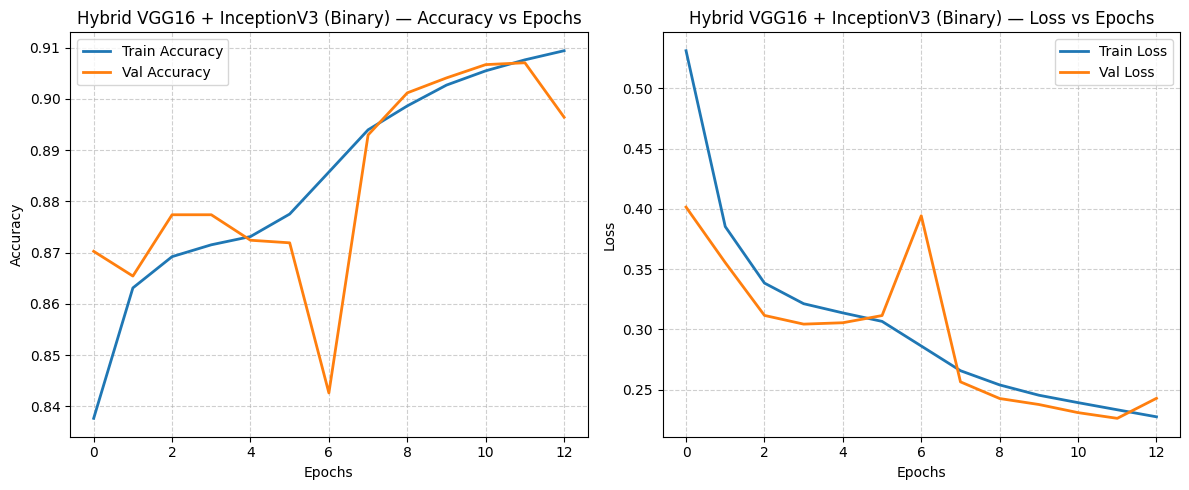

In [ ]:
import matplotlib.pyplot as plt

# ---------- Merge both stage histories ----------
def merge_histories(hist1, hist2):
    history = {}
    for k in hist1.history.keys():
        history[k] = hist1.history[k] + hist2.history[k]
    return history

full_history = merge_histories(history_top, history_ft)

# ---------- Plot Accuracy & Loss ----------
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(full_history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(full_history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('Hybrid VGG16 + InceptionV3 (Binary) — Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Loss plot
plt.subplot(1,2,2)
plt.plot(full_history['loss'], label='Train Loss', linewidth=2)
plt.plot(full_history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Hybrid VGG16 + InceptionV3 (Binary) — Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_curve, roc_auc_score, auc,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report)

# ------------------ Build test_ds with correct size & preprocess ------------------
TEST_BATCH = 32
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(BASE_DIR, "test"),
    label_mode="binary",
    image_size=(299, 299),   # MATCH model input
    batch_size=TEST_BATCH,
    shuffle=False,
    seed=SEED
)
# apply same preprocessing used for training
test_ds = test_ds.map(lambda x, y: (inception_preprocess(x), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

# ------------------ Collect predictions robustly ------------------
y_true_list = []
y_prob_list = []

for imgs, labels in test_ds:
    preds = hybrid_model.predict(imgs, verbose=0)   # shape may be (batch,1) or (batch,)
    # ensure we get 1D pos-class probabilities
    preds = np.array(preds).squeeze()
    y_prob_list.append(preds)
    y_true_list.extend(labels.numpy())

y_true = np.array(y_true_list, dtype=float)
y_prob = np.hstack(y_prob_list).astype(float)   # shape (N,)

# ------------------ Clean NaN / inf ------------------
mask = np.isfinite(y_prob)
if not np.all(mask):
    print(f"Removed {np.sum(~mask)} invalid prob entries (NaN/inf).")
y_true = y_true[mask]
y_prob = y_prob[mask]
N = len(y_true)
print(f"Using {N} samples for evaluation.\n")

# ------------------ ROC & AUC ------------------
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)
print(f"ROC-AUC: {roc_auc:.4f}")

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, lw=2.5, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid VGG16+InceptionV3 — ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# ------------------ Optimal threshold (Youden's J) ------------------
j_scores = tpr - fpr
j_best_idx = np.argmax(j_scores)
opt_thresh = thresholds[j_best_idx]
print(f"Optimal threshold (Youden's J): {opt_thresh:.4f}")
print(f"TPR @opt: {tpr[j_best_idx]:.4f}, FPR @opt: {fpr[j_best_idx]:.4f}\n")

# ------------------ Metrics at default 0.5 and at optimal threshold ------------------
def compute_metrics(y_true, y_prob, thresh):
    y_pred = (y_prob >= thresh).astype(int)
    return {
        'threshold': thresh,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_prob),
        'confusion': confusion_matrix(y_true, y_pred),
        'report': classification_report(y_true, y_pred, digits=4)
    }

metrics_05 = compute_metrics(y_true, y_prob, 0.5)
metrics_opt = compute_metrics(y_true, y_prob, opt_thresh)

# Print comparison table
print("Performance comparison\n----------------------")
print(f"{'Metric':<12} {'Thresh=0.5':>10} {'Thresh=opt':>12}")
print(f"{'Accuracy':<12} {metrics_05['accuracy']:10.4f} {metrics_opt['accuracy']:12.4f}")
print(f"{'Precision':<12} {metrics_05['precision']:10.4f} {metrics_opt['precision']:12.4f}")
print(f"{'Recall':<12} {metrics_05['recall']:10.4f} {metrics_opt['recall']:12.4f}")
print(f"{'F1-score':<12} {metrics_05['f1']:10.4f} {metrics_opt['f1']:12.4f}")
print(f"{'ROC-AUC':<12} {metrics_05['roc_auc']:10.4f} {metrics_opt['roc_auc']:12.4f}")

# ------------------ Confusion matrices ------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(metrics_05['confusion'], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (threshold=0.5)')
plt.xlabel('Predicted'); plt.ylabel('Actual')

plt.subplot(1,2,2)
sns.heatmap(metrics_opt['confusion'], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (threshold={opt_thresh:.4f})')
plt.xlabel('Predicted'); plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# ------------------ Detailed classification reports ------------------
print("\nClassification Report @ threshold=0.5\n-------------------------------------")
print(metrics_05['report'])
print("\nClassification Report @ optimal threshold\n-----------------------------------------")
print(metrics_opt['report'])


NameError: name 'tf' is not defined